In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#IMPORT

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize


#DATA GENERATOR

In [ ]:
IMG_SIZE = (224,224)
BATCH_SIZE = 128

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Daun_kentang/Training',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Daun_kentang/Validation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Daun_kentang/Testing',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3251 images belonging to 3 classes.
Found 416 images belonging to 3 classes.
Found 405 images belonging to 3 classes.


#MODEL

In [ ]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,619,203 (9.99 MB)

 Trainable params: 361,219 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

#TRAINING

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 564s 21s/step - accuracy: 0.4614 - loss: 1.1076 - val_accuracy: 0.8966 - val_loss: 0.4753
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8374 - loss: 0.4777 - val_accuracy: 0.9399 - val_loss: 0.2694
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8905 - loss: 0.3247 - val_accuracy: 0.9399 - val_loss: 0.2020
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9023 - loss: 0.2688 - val_accuracy: 0.9519 - val_loss: 0.1675
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9166 - loss: 0.2337 - val_accuracy: 0.9519 - val_loss: 0.1458
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9268 - loss: 0.1963 - val_accuracy: 0.9639 - val_loss: 0.1328
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9419 - loss: 0.1696 - val_accuracy: 0.9567 - val_loss: 0.1266
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9398 - loss: 0.1734 - val_accuracy: 0.9663 - val_los

#EVAL MODEL

In [ ]:
loss, acc = model.evaluate(test_gen)
print(f"Akurasi Test: {acc*100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 75s 25s/step - accuracy: 0.9524 - loss: 0.1468
Akurasi Test: 96.05%


#CONFUSION MATRIX

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


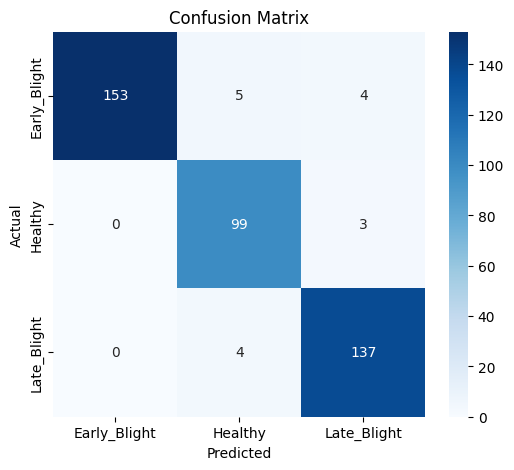

In [ ]:
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys(),
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#ROC MODEL

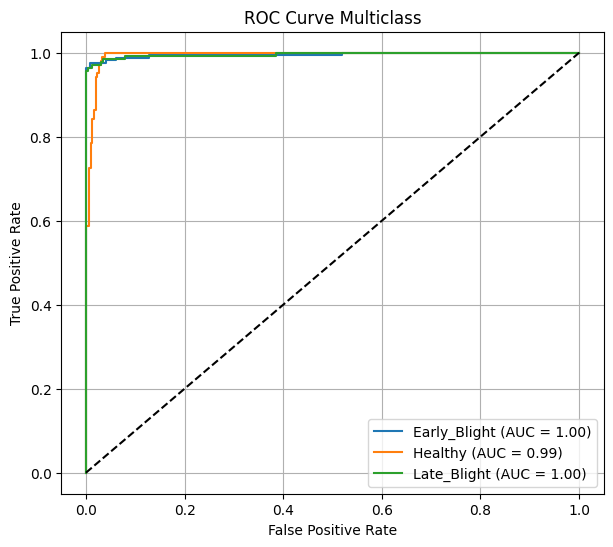

In [ ]:
n_classes = 3
y_true_bin = label_binarize(y_true, classes=[0,1,2])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,6))
for i, class_name in enumerate(test_gen.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Multiclass')
plt.legend()
plt.grid()
plt.show()


#SAVE MODEL

In [ ]:
model.save('/content/drive/MyDrive/Potato/model-mobilenet-2025-fix-good.h5')


#TEST

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array)
    classes = ['Early_Blight','Healthy','Late_Blight']

    return classes[np.argmax(preds)], np.max(preds)*100


In [ ]:
img_path = '/content/drive/MyDrive/PUI/Sehat/Healthy_109.jpg'
label, conf = predict_image(img_path)
print(f"Prediksi: {label}, Confidence: {conf:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Prediksi: Healthy, Confidence: 79.87%


#REPORT

In [ ]:
from sklearn.metrics import classification_report

# Label asli dan prediksi
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Nama kelas (urut sesuai folder)
class_names = list(test_gen.class_indices.keys())

# Tampilkan report
report = classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names,
    digits=4
)

print("=== Classification Report ===")
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 534ms/step
=== Classification Report ===
              precision    recall  f1-score   support

Early_Blight     1.0000    0.9444    0.9714       162
     Healthy     0.9167    0.9706    0.9429       102
 Late_Blight     0.9514    0.9716    0.9614       141

    accuracy                         0.9605       405
   macro avg     0.9560    0.9622    0.9586       405
weighted avg     0.9621    0.9605    0.9607       405

